# Classification

This notebook aims to obtain an accurate model able to predict whether the QQQ stock price is gonna increase or decrease over a full day. The model will be trained on the data from 2019 to 2022 and tested on the data from 2022 to 2023. Additional features will be used to improve the accuracy of the model, such as the interest rate and the inflation

## Libraries

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Data opening and exploration

## Data Opening

### QQQ data

In [2]:
data_2019 = pd.read_csv('Data\\2019 - FUND_US_XNAS_QQQ.csv')
data_2020 = pd.read_csv('Data\\2020 - FUND_US_XNAS_QQQ.csv')
data_2021 = pd.read_csv('Data\\2021 - FUND_US_XNAS_QQQ.csv')
data_2022 = pd.read_csv('Data\\2022 - FUND_US_XNAS_QQQ.csv')
data_2023 = pd.read_csv('Data\\2023 - FUND_US_XNAS_QQQ.csv')

# Concatenate all data into one big dataframe

data = pd.concat([data_2019, data_2020, data_2021, data_2022, data_2023])

# save the data to a csv file
data.to_csv('Data\\QQQ.csv')

In [14]:
# Check the data (name of columns, number of rows, etc.) and check if there are any missing values

print(data.info())
print(data.isnull().sum())

# convert the date column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

print(data.head())

<class 'pandas.core.frame.DataFrame'>
Index: 1220 entries, 0 to 211
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1220 non-null   object 
 1   Open    1220 non-null   float64
 2   High    1220 non-null   float64
 3   Low     1220 non-null   float64
 4   Close   1220 non-null   float64
 5   Volume  1220 non-null   object 
dtypes: float64(4), object(2)
memory usage: 66.7+ KB
None
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
        Date    Open    High     Low   Close      Volume
0 2019-12-31  211.62  212.76  211.20  212.61  18,201,590
1 2019-12-30  213.51  213.63  211.16  212.21  21,829,910
2 2019-12-27  214.55  214.56  213.04  213.61  18,142,240
3 2019-12-26  212.26  213.81  212.23  213.79  17,159,311
4 2019-12-24  211.97  212.09  211.44  211.92   7,089,020


### Inflation data

In [16]:
inflation_data = pd.read_csv('Data\\us_inflation.txt', sep='\t')
# transform the 'Year' into the index of the dataframe
inflation_data.set_index('Year', inplace=True)
print(inflation_data)

      Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec  HALF1  HALF2
Year                                                                          
2013  1.9  2.0  1.9  1.7  1.7  1.6  1.7  1.8  1.7  1.7  1.7  1.7    1.8    1.7
2014  1.6  1.6  1.7  1.8  2.0  1.9  1.9  1.7  1.7  1.8  1.7  1.6    1.8    1.7
2015  1.6  1.7  1.8  1.8  1.7  1.8  1.8  1.8  1.9  1.9  2.0  2.1    1.7    1.9
2016  2.2  2.3  2.2  2.1  2.2  2.2  2.2  2.3  2.2  2.1  2.1  2.2    2.2    2.2
2017  2.3  2.2  2.0  1.9  1.7  1.7  1.7  1.7  1.7  1.8  1.7  1.8    2.0    1.7
2018  1.8  1.8  2.1  2.1  2.2  2.3  2.4  2.2  2.2  2.1  2.2  2.2    2.1    2.2
2019  2.2  2.1  2.0  2.1  2.0  2.1  2.2  2.4  2.4  2.3  2.3  2.3    2.1    2.3
2020  2.3  2.4  2.1  1.4  1.2  1.2  1.6  1.7  1.7  1.6  1.6  1.6    1.8    1.6
2021  1.4  1.3  1.6  3.0  3.8  4.5  4.3  4.0  4.0  4.6  4.9  5.5    2.6    4.5
2022  6.0  6.4  6.5  6.2  6.0  5.9  5.9  6.3  6.6  6.3  6.0  5.7    6.2    6.1
2023  5.6  5.5  5.6  5.5  5.3  4.8  4.7  4.3  4.1  N

### Interest rate data

In [13]:
ir_data = pd.read_csv('Data\\interest_rate_n.csv')

# convert the date column to datetime format
ir_data['Date'] = pd.to_datetime(ir_data['Date'])
print(ir_data.head())

        Date 1-month 3-month 6-month 1-year 2-year 3-year 5-year 7-year  \
0 1962-01-02     NaN     NaN     NaN   3.22    NaN   3.70   3.88    NaN   
1 1962-01-03     NaN     NaN     NaN   3.24    NaN   3.70   3.87    NaN   
2 1962-01-04     NaN     NaN     NaN   3.24    NaN   3.69   3.86    NaN   
3 1962-01-05     NaN     NaN     NaN   3.26    NaN   3.71   3.89    NaN   
4 1962-01-08     NaN     NaN     NaN   3.31    NaN   3.71   3.91    NaN   

  10-year 20-year 30-year  
0    4.06    4.07     NaN  
1    4.03    4.07     NaN  
2    3.99    4.06     NaN  
3    4.02    4.07     NaN  
4    4.03    4.08     NaN  


## Full data

We will now merge the three datasets into one, while keeping only the dates that are common to the three datasets.

In [15]:
full_data = pd.merge(data, ir_data, on='Date')
print(full_data.head())

        Date    Open    High     Low   Close      Volume 1-month 3-month  \
0 2019-12-31  211.62  212.76  211.20  212.61  18,201,590    1.48    1.55   
1 2019-12-30  213.51  213.63  211.16  212.21  21,829,910    1.51    1.57   
2 2019-12-27  214.55  214.56  213.04  213.61  18,142,240    1.56    1.57   
3 2019-12-26  212.26  213.81  212.23  213.79  17,159,311    1.59    1.58   
4 2019-12-24  211.97  212.09  211.44  211.92   7,089,020    1.55    1.58   

  6-month 1-year 2-year 3-year 5-year 7-year 10-year 20-year 30-year  
0    1.60   1.59   1.58   1.62   1.69   1.83    1.92    2.25    2.39  
1    1.60   1.57   1.58   1.59   1.68   1.81    1.90    2.21    2.34  
2    1.59   1.51   1.59   1.60   1.68   1.80    1.88    2.18    2.32  
3    1.61   1.53   1.64   1.65   1.72   1.85    1.90    2.19    2.33  
4    1.61   1.53   1.62   1.64   1.72   1.83    1.90    2.20    2.33  


In [18]:
# to add the values in the inflation dataframe, we are going to look first for the year and then for the month

def join_inflation(row):
    year = row['Date'].year
    month = row['Date'].month
    # convert the month to a 3-char string
    month = row['Date'].strftime('%b')
    return inflation_data.loc[year, month]

full_data['Inflation'] = full_data.apply(join_inflation, axis=1)
print(full_data.head())

        Date    Open    High     Low   Close      Volume 1-month 3-month  \
0 2019-12-31  211.62  212.76  211.20  212.61  18,201,590    1.48    1.55   
1 2019-12-30  213.51  213.63  211.16  212.21  21,829,910    1.51    1.57   
2 2019-12-27  214.55  214.56  213.04  213.61  18,142,240    1.56    1.57   
3 2019-12-26  212.26  213.81  212.23  213.79  17,159,311    1.59    1.58   
4 2019-12-24  211.97  212.09  211.44  211.92   7,089,020    1.55    1.58   

  6-month 1-year 2-year 3-year 5-year 7-year 10-year 20-year 30-year  \
0    1.60   1.59   1.58   1.62   1.69   1.83    1.92    2.25    2.39   
1    1.60   1.57   1.58   1.59   1.68   1.81    1.90    2.21    2.34   
2    1.59   1.51   1.59   1.60   1.68   1.80    1.88    2.18    2.32   
3    1.61   1.53   1.64   1.65   1.72   1.85    1.90    2.19    2.33   
4    1.61   1.53   1.62   1.64   1.72   1.83    1.90    2.20    2.33   

   Inflation  
0        2.3  
1        2.3  
2        2.3  
3        2.3  
4        2.3  


In [19]:
# Now save the full data to a csv file
full_data.to_csv('Data\\QQQ_full.csv')

## Data exploration

We are going to print the first rows of the dataset, as well as the number of rows and columns.
Then we will print basic statistics about the dataset, as well as the correlation matrix.
And finally we will plot the evolution of the QQQ stock price over time.

              Open    High     Low   Close    Volume 1-month 3-month 6-month  \
Date                                                                           
2019-01-02  150.99  155.75  150.88  154.88  58576672    2.40    2.42    2.51   
2019-01-03  152.60  153.26  149.49  149.82  74820234    2.42    2.41    2.47   
2019-01-04  152.18  157.00  151.74  156.23  74709320    2.40    2.42    2.51   
2019-01-07  156.54  158.86  156.11  158.09  52059328    2.42    2.45    2.54   
2019-01-08  159.56  160.11  157.20  159.52  49388688    2.40    2.46    2.54   

           1-year 2-year 3-year 5-year 7-year 10-year 20-year 30-year  \
Date                                                                    
2019-01-02   2.60   2.50   2.47   2.49   2.56    2.66    2.83    2.97   
2019-01-03   2.50   2.39   2.35   2.37   2.44    2.56    2.75    2.92   
2019-01-04   2.57   2.50   2.47   2.49   2.56    2.67    2.83    2.98   
2019-01-07   2.58   2.53   2.51   2.53   2.60    2.70    2.86    2.99   
2

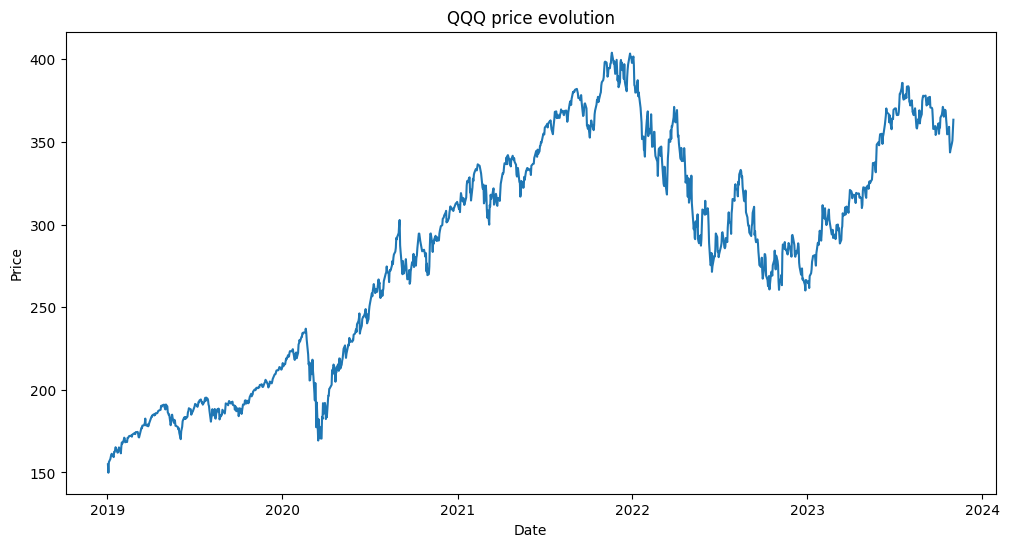

In [30]:
Full_dataset = pd.read_csv('Data\\QQQ_full.csv')
Full_dataset['Date'] = pd.to_datetime(Full_dataset['Date'])
Full_dataset.set_index('Date', inplace=True)

# delete the columns 'Unnamed: 0'
Full_dataset.drop('Unnamed: 0', axis=1, inplace=True)

# sort the dataset by growing date
Full_dataset.sort_index(inplace=True)

# Convert the 'Volume' values to integers by removing the commas
Full_dataset['Volume'] = Full_dataset['Volume'].str.replace(',', '')
Full_dataset['Volume'] = Full_dataset['Volume'].astype(int)

print(Full_dataset.head())

# print the number of rows and columns
print(Full_dataset.shape)
print(Full_dataset.info())
print(Full_dataset.columns)

# print basic statistics
print(Full_dataset.describe())

# print the correlation matrix with seaborn
'''corr = Full_dataset.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')'''

# print the evolution of the price
plt.figure(figsize=(12, 6))
plt.plot(Full_dataset.index, Full_dataset['Close'])
plt.title('QQQ price evolution')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Random forest classifier

Our goal is to predict wethever the QQQ stock price is going to increase or decrease over a full day. We will use a random forest classifier to do so.
First we are going to add a "label" column to the dataframe, with 1 if the stock price increased over a full day, and 0 otherwise.

In [41]:
# Add the column
def add_column(row):
    return int(row['Close'] > row['Open'])

Full_dataset['Price_diff'] = Full_dataset.apply(add_column, axis=1)

# then we copy it to drop the 'Open' and 'Close' columns
dataset = Full_dataset.copy()
dataset.drop(['Close'], axis=1, inplace=True)

# Drop rows with missing values or with non-numeric values
dataset.dropna(inplace=True)
dataset = dataset[dataset.apply(lambda x: pd.to_numeric(x, errors='coerce').notna()).all(1)]

print(dataset.head())

              Open    High     Low    Volume 1-month 3-month 6-month 1-year  \
Date                                                                          
2019-01-02  150.99  155.75  150.88  58576672    2.40    2.42    2.51   2.60   
2019-01-03  152.60  153.26  149.49  74820234    2.42    2.41    2.47   2.50   
2019-01-04  152.18  157.00  151.74  74709320    2.40    2.42    2.51   2.57   
2019-01-07  156.54  158.86  156.11  52059328    2.42    2.45    2.54   2.58   
2019-01-08  159.56  160.11  157.20  49388688    2.40    2.46    2.54   2.60   

           2-year 3-year 5-year 7-year 10-year 20-year 30-year  Inflation  \
Date                                                                        
2019-01-02   2.50   2.47   2.49   2.56    2.66    2.83    2.97        2.2   
2019-01-03   2.39   2.35   2.37   2.44    2.56    2.75    2.92        2.2   
2019-01-04   2.50   2.47   2.49   2.56    2.67    2.83    2.98        2.2   
2019-01-07   2.53   2.51   2.53   2.60    2.70    2.86    2.9

Now we train/test split the data

In [42]:
train_dataset = dataset.loc['2019-01-01':'2020-12-31']
test_dataset = dataset.loc['2021-01-01':'2021-12-31']

X_train = train_dataset.drop('Price_diff', axis=1)
y_train = train_dataset['Price_diff']
X_test = test_dataset.drop('Price_diff', axis=1)
y_test = test_dataset['Price_diff']

## Model definition and training

We are going to use a random forest classifier to predict the label of the data. We will use the default parameters of the classifier.

In [44]:
# Create the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Define the hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Fit the model with the best hyperparameters
best_rf_model = RandomForestClassifier(**best_params)
best_rf_model.fit(X_train, y_train)

# Evaluate the model on the test set
accuracy = best_rf_model.score(X_test, y_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


## Results

In [45]:
print('Accuracy:', accuracy)
print('Best hyperparameters:', best_params)

Accuracy: 0.428
Best hyperparameters: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


# Gradient boosting classifier

In [46]:
# Add the column
def add_column(row):
    return int(row['Close'] > row['Open'])

Full_dataset['Price_diff'] = Full_dataset.apply(add_column, axis=1)

# then we copy it to drop the 'Open' and 'Close' columns
dataset = Full_dataset.copy()
dataset.drop(['Close'], axis=1, inplace=True)

# Drop rows with missing values or with non-numeric values
dataset.dropna(inplace=True)
dataset = dataset[dataset.apply(lambda x: pd.to_numeric(x, errors='coerce').notna()).all(1)]

train_dataset = dataset.loc['2019-01-01':'2020-12-31']
test_dataset = dataset.loc['2021-01-01':'2021-12-31']

X_train = train_dataset.drop('Price_diff', axis=1)
y_train = train_dataset['Price_diff']
X_test = test_dataset.drop('Price_diff', axis=1)
y_test = test_dataset['Price_diff']

## Model definition and training

In [48]:


# Create the Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier()

# Define the hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(gb_classifier, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Fit the model with the best hyperparameters
best_gb_model = GradientBoostingClassifier(**best_params)
best_gb_model.fit(X_train, y_train)

# Evaluate the model on the test set
accuracy = best_gb_model.score(X_test, y_test)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


## Results

In [49]:
print('Accuracy:', accuracy)
print('Best hyperparameters:', best_params)

Accuracy: 0.48
Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
